In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, prange

In [15]:
@njit(parallel=False)
def numba_sum_axis0(x : np.array) -> np.array:
    assert len(x.shape) == 2, "Input must be 2D array shape but got shape"

    x_out = np.empty(x.shape[1])
    for i in range(x.shape[1]):
        x_out[i] = np.sum(x[:,i])
    return x_out

@njit(parallel=False)
def numba_sum_axis1(x : np.array) -> np.array:
    assert len(x.shape) == 3, "Input must be 3d array shape but got shape"

    x_out = np.empty((x.shape[0], x.shape[2]))
    for i in range(x.shape[0]):
        for j in range(x.shape[2]):
            x_out[i,j] = np.sum(x[i,:,j])
   
    return x_out

@njit(parallel=False)
def numba_sum_axis2(x : np.array) -> np.array:
    assert len(x.shape) == 3, "Input must be 3D array shape but got shape"

    x_out = np.empty((x.shape[0], x.shape[1]))
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x_out[i,j] = np.sum(x[i,j,:])
    return x_out

In [16]:
np.random.seed(421)


reflexive : int = 0
dt = 0.02
steps_per_orbit = 100


Cdt = 2.*np.pi / steps_per_orbit


sun_pos_vel_acc = np.zeros((1, 3, 2))
sun_mass = np.array([1.])

@njit(parallel=False)
def get_acceleration(particles, heavy_particles, heavy_masses) -> np.ndarray:
    positions = particles[:,0]
    heavy_positions = heavy_particles[:,0]

    accelerations = np.empty_like(positions)

    # for i in prange(positions.shape[0]):
    #     pos = positions[i]
    #     # for j in prange(heavy_positions.shape[0]):
    #     #     heavy_pos = heavy_positions[j]

    #     #     dir = pos-heavy_pos
    #     #     dist = np.sqrt(np.sum(dir*dir))

    #     #     # calculate the acceleration
    #     #     acc = -dir * 4. * np.pi*np.pi * heavy_masses[j]/(dist*dist*dist)

    #     #     # add the acceleration to the acceleration array
    #     #     accelerations[i] = acc

    #     # the same as above. but using vectorized operations
    #     dir = pos-heavy_positions
    #     dist = np.sqrt(np.sum(dir*dir))

    #     acc = -dir[0] * 4. * np.pi*np.pi * heavy_masses/((dist*dist*dist))

    #     accelerations[i] = acc

    # everyting vectorized
        
    dir = positions[:,None] - heavy_positions
    dist = np.sqrt(numba_sum_axis2(dir*dir))

    acc = -dir * 4. * np.pi*np.pi * heavy_masses/((dist*dist*dist))[:,:,None]

    accelerations = numba_sum_axis1(acc)



    return accelerations


@njit
def courant(particles, heavy_particles) -> None:
    pass


@njit
def kick(particles, heavy_particles, heavy_masses, dt) -> np.ndarray:
    """ Kick the particles using the current acceleration """

    particles[:,2] = get_acceleration(particles, heavy_particles, heavy_masses)

    particles[:,1] += particles[:,2] * (0.5*dt)

    return particles

@njit
def drift(particles, dt) -> None:
    """ Drift the particles using the current velocity """
    particles[:,0] += particles[:,1] * dt

    return particles

@njit
def single_kdk(particles, heavy_particles, heavy_masses, dt) -> tuple[np.ndarray, np.ndarray]:
    heavy_particles = kick(heavy_particles, sun_pos_vel_acc, sun_mass, dt)
    heavy_particles = drift(heavy_particles, dt)
    heavy_particles = kick(heavy_particles, sun_pos_vel_acc, sun_mass, dt)

    particles = kick(particles, heavy_particles, heavy_masses, dt)
    particles = kick(particles, sun_pos_vel_acc, sun_mass, dt)
    particles = drift(particles, dt) 
    particles = kick(particles, heavy_particles, heavy_masses, dt)
    particles = kick(particles, sun_pos_vel_acc, sun_mass, dt)

    return particles, heavy_particles

@njit
def step(particles, heavy_particles, heavy_masses, dt) -> tuple[np.ndarray, np.ndarray]:  
    """ Take a single Kick-Drift-Drift timestep """
    # if reflexive dt condition used, store old particle positions, velocities, and dts
    # remember to use "np.copy" to take a real copy of the variables.
    if reflexive > 0:
        olddt = dt
        old_particles = np.copy(particles)
        old_heavy_particles = np.copy(heavy_particles)


    # take a single KDK step
    particles, heavy_particles = single_kdk(particles, heavy_particles, heavy_masses, dt)

    # if reflexive dt condition used, recompute dt, and
    # use averaged dt to redo the KDK step "reflexive" times
    # from stored positions and velocities
    if reflexive > 0:
        # make n more iteration for completeness
        for _ in prange(reflexive):
            # courant(particles,heavy_particles)
            dt = 0.5*(dt + olddt)

            particles = np.copy(old_particles)
            heavy_particles = np.copy(old_heavy_particles)

            particles, heavy_particles = single_kdk(particles, heavy_particles, heavy_masses, dt)

    return particles, heavy_particles

def courant(pos_vel_acc, kepler_speeds) -> float:
    acceleration = pos_vel_acc[:,2]
    acc = np.sqrt(numba_sum_axis0(acceleration*acceleration))
    dts = Cdt * kepler_speeds / acc

    return np.min(dts)

@njit
def main(dt):
    N_dust = 400
    N_heavy = 1
    pos_vel_acc = np.zeros((N_dust, 3, 2))
    kepler_speeds = np.zeros(N_dust)
    GM = 4. * np.pi*np.pi * 1

    dists = np.linspace(2., 4., N_dust)
    for i in range(N_dust):
        # dist = 1.5 + np.random.uniform()*3.5
        dist = dists[i]
        e = 0.
        a = dist/(1 + e)
        vm = np.sqrt(GM*(2/dist - 1/a))            # Kepler speed
        angle = np.random.uniform()*2*np.pi

        vx = -vm*np.sin(angle)
        vy = +vm*np.cos(angle) 

        pos_vel_acc[i,0,0] = np.cos(angle)*dist
        pos_vel_acc[i,0,1] = np.sin(angle)*dist
        pos_vel_acc[i,1,0] = vx
        pos_vel_acc[i,1,1] = vy
        kepler_speeds[i] = vm

        
    heavy_pos_vel_acc = np.zeros((N_heavy, 3, 2))
    heavy_masses = np.ones(N_heavy)*0.000954588


    for i in range(N_heavy):
        dist = 5.2
        e = 0.
        a = dist/(1 + e)
        vm = np.sqrt(GM*(2/dist - 1/a))         # Kepler speed

        angle = np.random.uniform()*2*np.pi
        
        vx = -vm*np.sin(angle)
        vy = +vm*np.cos(angle) 

        heavy_pos_vel_acc[i,0,0] = np.cos(angle)*dist 
        heavy_pos_vel_acc[i,0,1] = np.sin(angle)*dist
        heavy_pos_vel_acc[i,1,0] = vx
        heavy_pos_vel_acc[i,1,1] = vy

    n_steps = int(2e6)

    all_positions = np.zeros((n_steps, N_dust, 2))

    all_positions[0] = pos_vel_acc[:,0,:]

    all_heavy_positions = np.zeros((n_steps, N_heavy, 2))
    all_heavy_positions[0] = heavy_pos_vel_acc[:,0,:]

    for i in prange(n_steps):
        pos_vel_acc, heavy_pos_vel_acc = step(pos_vel_acc, heavy_pos_vel_acc, heavy_masses, dt)
        all_positions[i] = pos_vel_acc[:,0,:]
        all_heavy_positions[i] = heavy_pos_vel_acc[:,0,:]


    return all_positions, all_heavy_positions



all_positions, all_heavy_positions = main(dt)

    



In [3]:
np.save("400positions2e6.npy", all_positions)
np.save("1heavypositions2e6.npy", all_heavy_positions)

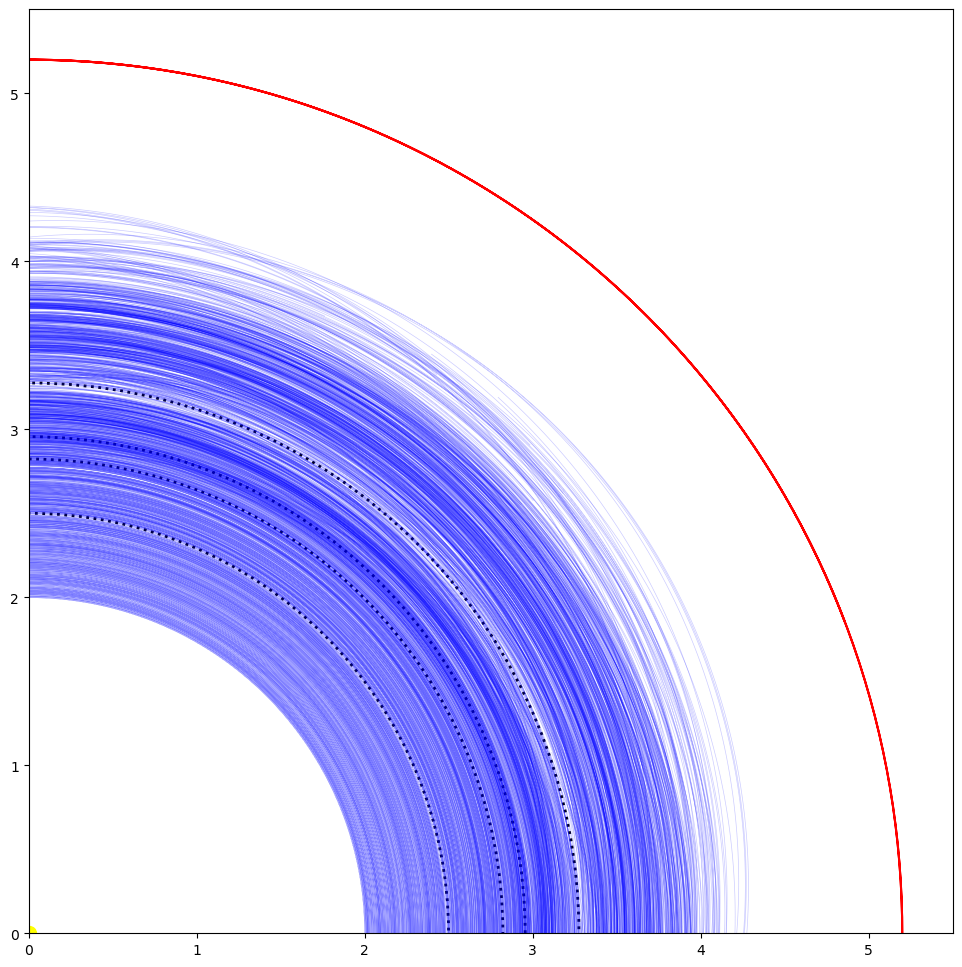

In [17]:
def P_from_a(a):
    return np.sqrt(4*np.pi**2*a**3)

def a_from_P(P):
    return (P**2/(4*np.pi**2))**(1/3)



a_jupiter = 5.2
P_jupiter = P_from_a(a_jupiter)


last_n = 1600

fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')

plt.plot(all_heavy_positions[-last_n:,0,0], all_heavy_positions[-last_n:,0,1], c = 'red')
plt.plot(all_positions[-last_n:,:,0], all_positions[-last_n:,:,1], c = 'blue', alpha=0.2, lw=0.5)

for frac in [1/3, 2/5, 3/7, 1/2]:
    distance = a_from_P(P_jupiter*frac)

    # plot circle at distance
    circle = plt.Circle((0, 0), distance, ls = ':',color='black', fill=False, lw = 2)
    ax.add_artist(circle)

# for frac in [1/5, 1/4, 2/5, 2/3, 3/4]:
#     distance = a_from_P(P_jupiter*frac)

#     # plot circle at distance
#     circle = plt.Circle((0, 0), distance, ls = '--',color='black', fill=False, alpha = 0.2)
#     ax.add_artist(circle)


plt.plot([0], [0], 'o', color='yellow', markersize=10)

plt.xlim(0,5.5)
plt.ylim(0,5.5)
plt.show()

(-1.0, 10.0)

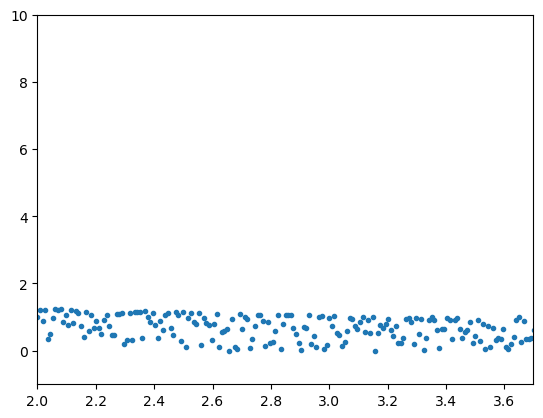

In [18]:
last_dists = np.sqrt(all_positions[-1]**2).sum(axis=1)
start_dists = np.linspace(1.5, 5.0, last_dists.shape[0])



plt.plot(start_dists, np.abs(start_dists - last_dists), '.', alpha=1)
plt.xlim(2, 3.7)
plt.ylim(-1,10)
# plt.ylim(

In [19]:
xx = all_positions[-last_n:,:,0]
yy = all_positions[-last_n:,:,1]


yy = yy[(xx > 2)*(xx<3.75)]
xx = xx[(xx > 2)*(xx<3.75)]

xx = xx[(yy < 0.1)*(yy > -0.1)]
yy = yy[(yy < 0.1)*(yy > -0.1)]


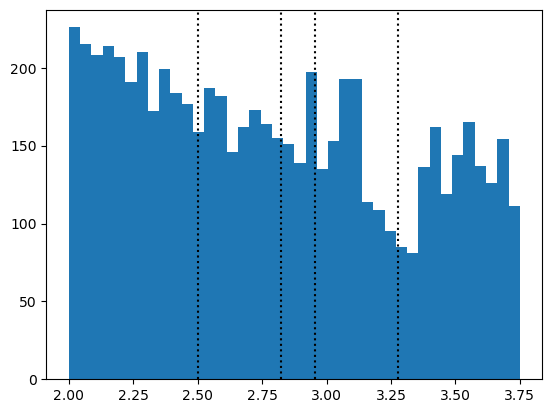

In [20]:
plt.hist(xx, bins=40)

for frac in [1/3, 2/5, 3/7, 1/2]:
    distance = a_from_P(P_jupiter*frac)

    plt.axvline(distance, ls = ':',color='black',)
plt.show()